# Landscape View Xenium

In [2]:
%load_ext autoreload
%autoreload 2
%env ANYWIDGET_HMR=1

env: ANYWIDGET_HMR=1


In [3]:
# macOS requirement
import os
os.environ['DYLD_LIBRARY_PATH'] = '/opt/homebrew/lib:' + os.environ.get('DYLD_LIBRARY_PATH', '')

In [4]:
from http.server import HTTPServer, SimpleHTTPRequestHandler
import pandas as pd
import threading as thr
import requests as rq
import scanpy as sc
import celldega as dega
import scanpy as sc
from ipywidgets import Widget

hello


In [5]:
class CORSHTTPRequestHandler(SimpleHTTPRequestHandler):
    def end_headers(self):
        self.send_header('Access-Control-Allow-Origin', '*')
        self.send_header('Access-Control-Allow-Methods', 'GET, OPTIONS')
        self.send_header('Access-Control-Allow-Headers', 'X-Requested-With, content-type, Authorization')  # Added Authorization
        self.send_header('Access-Control-Allow-Credentials', 'true')
        super().end_headers()

    def do_OPTIONS(self):
        self.send_response(200)
        self.end_headers()

    def log_message(self, format, *args):
        # Override log_message to prevent logging to the console.
        pass


server = HTTPServer(("", 0), CORSHTTPRequestHandler)
print(f"Server running on port {server.server_address[1]}")
/
service = thr.Thread(target=server.serve_forever)
service.start()

server_address = server.server_address[1]
server_address

Server running on port 63539


63539

# iST Landscape View

In [6]:
pwd

'/Users/jishar/Documents/celldega/notebooks'

In [7]:
base_url = f'http://localhost:{server_address}/data/xenium_landscapes/Xenium_Prime_Human_Skin_FFPE_outs'

In [8]:
Widget.close_all()
landscape_ist = dega.viz.Landscape(
    technology='Xenium',
    ini_zoom = -4.5,
    ini_x=6000,
    ini_y=8000,
    base_url = base_url,
    
)

landscape_ist

Landscape(base_url='http://localhost:63539/data/xenium_landscapes/Xenium_Prime_Human_Skin_FFPE_outs', ini_x=60…

### Scanpy

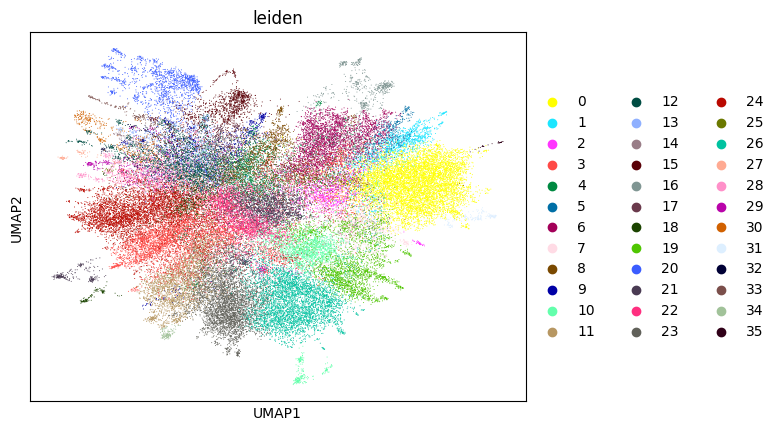

In [39]:
adata = sc.read_10x_h5('../data/xenium_data/Xenium_V1_hBoneMarrow_nondiseased_section_outs/cell_feature_matrix.h5')


sc.pp.filter_cells(adata, min_genes=3)
sc.pp.filter_genes(adata, min_cells=3)

# Saving count data
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)
sc.pl.umap(adata, color=["leiden"])


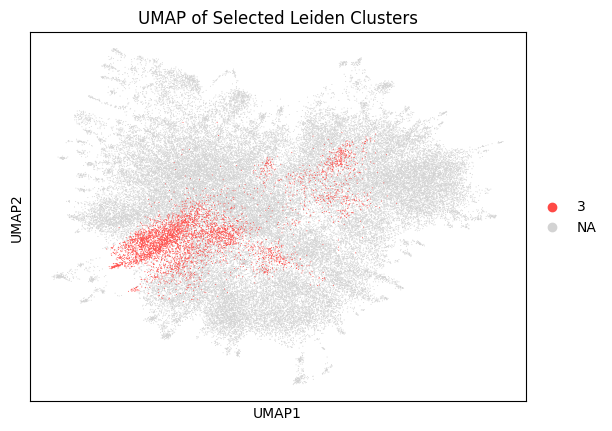

In [40]:
import scanpy as sc

# Assuming 'adata' is your AnnData object and 'leiden' is the clustering result
# Specify the clusters you want to inspect
clusters_of_interest = ['3']

# Plot the UMAP for the subset of clusters
sc.pl.umap(adata, color='leiden', groups=clusters_of_interest, title='UMAP of Selected Leiden Clusters')


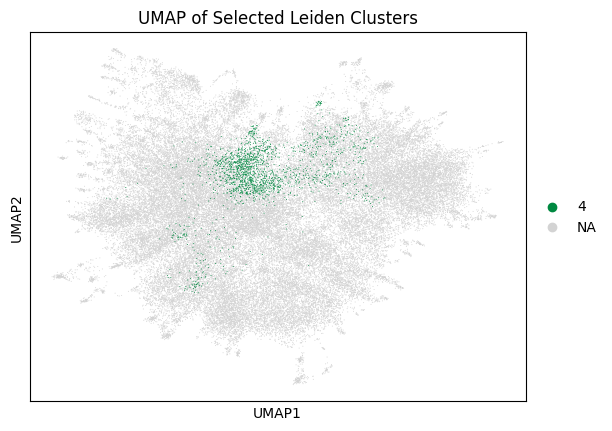

In [41]:
import scanpy as sc

# Assuming 'adata' is your AnnData object and 'leiden' is the clustering result
# Specify the clusters you want to inspect
clusters_of_interest = ['4']

# Plot the UMAP for the subset of clusters
sc.pl.umap(adata, color='leiden', groups=clusters_of_interest, title='UMAP of Selected Leiden Clusters')


### Cell Metadata

In [42]:
clusters = adata.obs['leiden'].cat.categories.tolist()
colors = adata.uns['leiden_colors']
ser_counts = adata.obs['leiden'].value_counts()
ser_color = pd.Series(colors, index=clusters, name='color')
meta_cluster = pd.DataFrame(ser_color)
meta_cluster['count'] = ser_counts
meta_cluster.index = ['leiden-' + str(x) for x in meta_cluster.index]
meta_cluster.head()

,color,count
leiden-0,#ffff00,7171
leiden-1,#1ce6ff,1383
leiden-2,#ff34ff,874
leiden-3,#ff4a46,4720
leiden-4,#008941,1889


In [43]:
len(str(meta_cluster.to_json(orient='records')))

1168

In [44]:
adata.obs['leiden'].shape

(62195,)

In [45]:
all_cells = pd.read_parquet('data/Xenium_V1_hBoneMarrow_nondiseased_section_outs/cell_metadata.parquet').index.tolist()

In [46]:
new_clusters = pd.DataFrame(index=all_cells)
new_clusters['leiden'] = adata.obs['leiden']
new_clusters_list = ['leiden-' + str(x) for x in new_clusters['leiden'].values.tolist()]

In [52]:
meta_cluster_dict = meta_cluster.to_dict()
new_cluster_info = {}
new_cluster_info['meta_cluster'] = meta_cluster_dict
new_cluster_info['new_clusters'] = new_clusters_list

In [53]:
len(str(new_cluster_info))

1099113

In [9]:
Widget.close_all()
landscape_ist = dega.viz.Landscape(
    technology='Xenium',
    ini_zoom = -4.5,
    ini_x=6000,
    ini_y=8000,
    base_url = base_url,
    
)

landscape_ist

Landscape(base_url='http://localhost:50732/data/xenium_landscapes/Xenium_Prime_Human_Skin_FFPE_outs', ini_x=60…

### Update with new cluster labels

In [59]:
landscape_ist.update_cell_clusters(new_cluster_info)